#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import lightgbm as lgb
import lightgbm as lgm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter('ignore')

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [ ]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


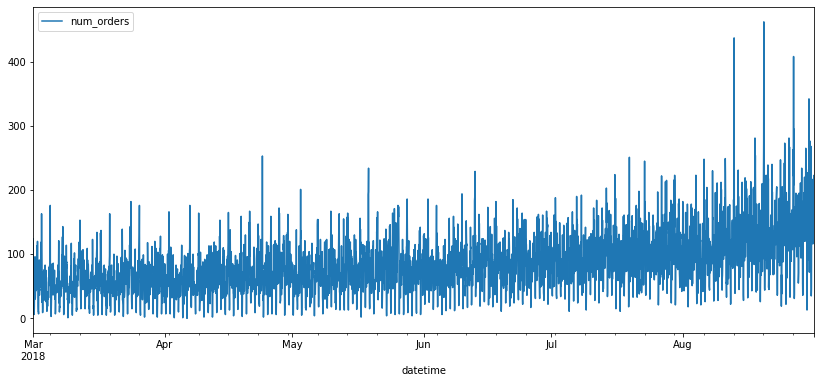

In [ ]:
data = data.resample('1H').sum()
data.plot(figsize = (14,6))
plt.show()

In [ ]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [ ]:
data.index.is_monotonic

True

Количество строк после ресемплирования стало меньше. Данные расположены в хронологическом порядке

## Анализ

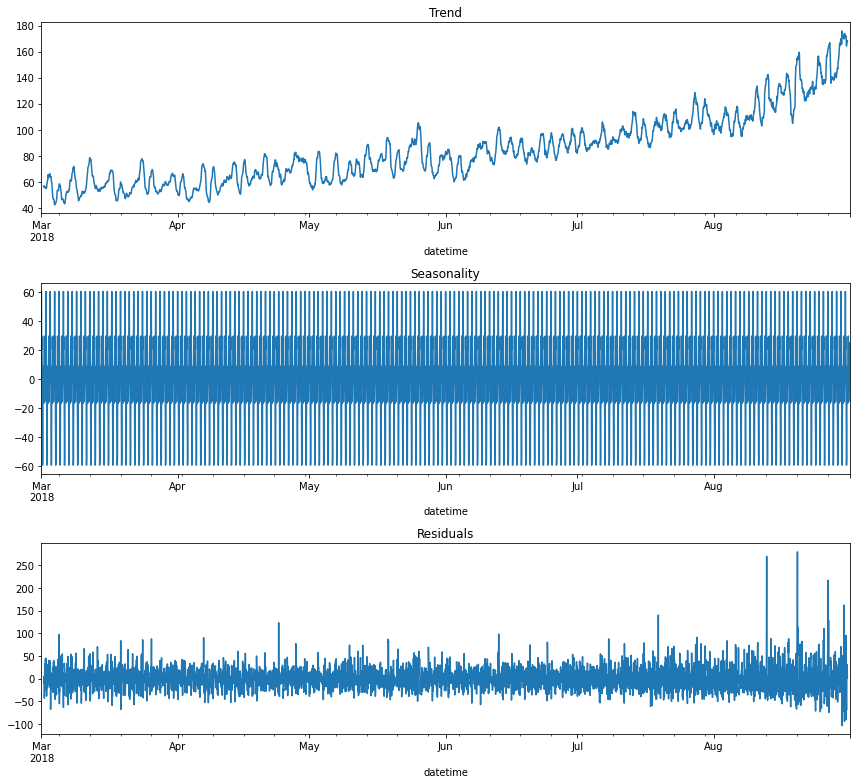

In [ ]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 11))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Тренд повышается начиная с лета и до сентября. Посмотрим на тренды и сезонность за последние 15 дней.

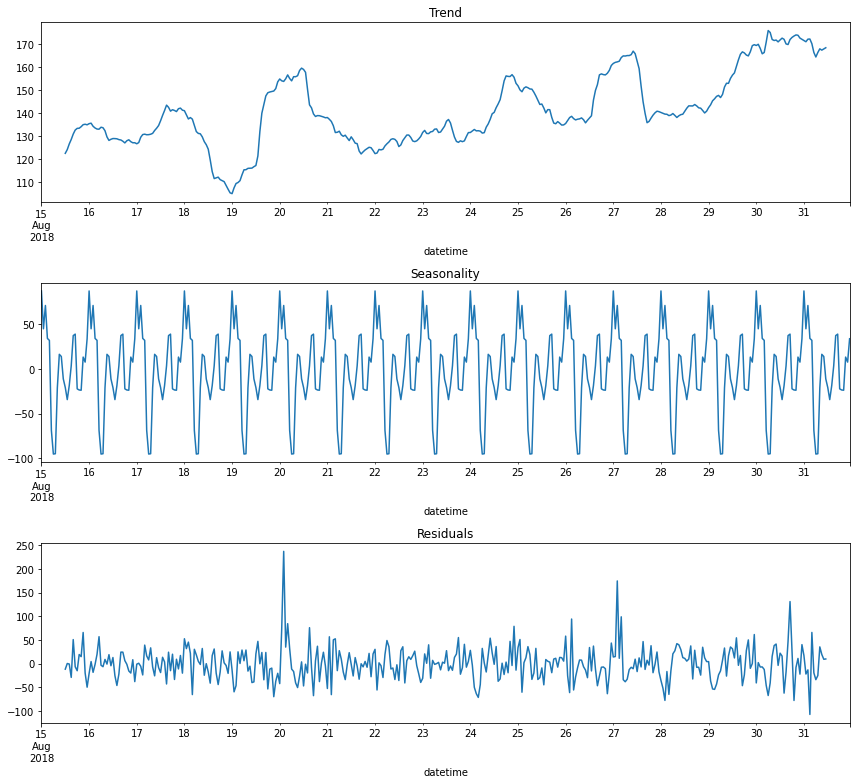

In [ ]:
decomposed = seasonal_decompose(data['2018-08-15':'2018-08-31'])
plt.figure(figsize=(12, 11))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

В сезонности видна динамика, возмем данные за один день.

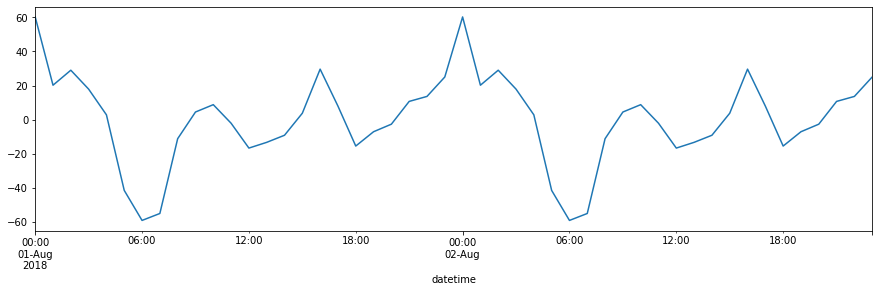

In [ ]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 14))
plt.subplot(311)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca());

Видно, что с 6 часов количество заказов увеличивается, пик приходится на 00.00 часов.

## Обучение

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(data, 40, 50)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,156.0,227.0,226.0,166.0,39.0,13.0,56.0,186.0,193.0,169.64
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,173.0,156.0,227.0,226.0,166.0,39.0,13.0,56.0,186.0,169.18
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,154.0,173.0,156.0,227.0,226.0,166.0,39.0,13.0,56.0,169.86


In [ ]:
data = data.dropna()

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

##### LinearRegression

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
RND = 12345

In [ ]:
lr_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [ ]:
%%time
lr_grid = GridSearchCV(LinearRegression(), param_grid = lr_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)

lr_best_params = lr_grid.best_params_
lr_model = LinearRegression(**lr_best_params)
lr_model.fit(features_train, target_train)
    
lr_test_pred = lr_model.predict(features_test)

print('Лучшие гиперпараметры: ', lr_best_params)
print('RMSE тестовой выборки: {:.2f}'.format(mean_squared_error(target_test, lr_test_pred)**0.5))

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
RMSE тестовой выборки: 44.85
CPU times: user 3.26 s, sys: 5.12 s, total: 8.38 s
Wall time: 8.53 s


##### RandomForestRegressor

In [ ]:
rf_params = {'n_estimahttps://k8s.jupyterhub.praktikum-services.ru/user/user-0-201033368/notebooks/95598b13-2680-44f4-8f06-d6eafb26e375.ipynb#RandomForestRegressortors' : range(50, 101, 10), 'max_depth' : range(5, 15, 2), 'verbose' : [0], 'random_state' : [RND]}

In [ ]:
%%time
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_params = rf_grid.best_params_
rf_model = RandomForestRegressor(**rf_best_params)
rf_model.fit(features_train, target_train)
    
rf_test_pred = rf_model.predict(features_test)

print('Лучшие гиперпараметры: ', rf_best_params)
print('RMSE тестовой выборки: {:.2f}'.format(mean_squared_error(target_test, rf_test_pred)**0.5))

Лучшие гиперпараметры:  {'max_depth': 13, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE тестовой выборки: 44.37
CPU times: user 4min 52s, sys: 1.22 s, total: 4min 53s
Wall time: 4min 53s


##### LGBMRegressor

In [ ]:
lgb_params = {'n_estimators' : range(50, 101, 10), 'max_depth' : range(5, 15, 2), 'verbose' : [0], 'random_state' : [RND]}

In [ ]:
%%time
lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lgb_grid.fit(features_train, target_train)

lgb_best_params = lgb_grid.best_params_
lgb_model = LGBMRegressor(**lgb_best_params)
lgb_model.fit(features_train, target_train)
    
lgb_test_pred = lgb_model.predict(features_test)

print('Лучшие гиперпараметры: ', lgb_best_params)
print('RMSE тестовой выборки: {:.2f}'.format(mean_squared_error(target_test, lgb_test_pred)**0.5))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

##### CatBoost

In [ ]:
cb_params = {'learning_rate':[0.1, 0.3, 0.5]}

In [ ]:
%%time
cb_grid= GridSearchCV(CatBoostRegressor(iterations=100, verbose=False), cb_params, scoring='neg_mean_squared_error',  cv=tscv , n_jobs = -1)
cb_grid.fit(features_train, target_train)

cb_best_params = cb_grid.best_params_
cb_model = CatBoostRegressor(**cb_best_params)
cb_model.fit(features_train, target_train)
    
cb_test_pred = cb_model.predict(features_test)

print('Лучшие гиперпараметры: ', cb_best_params)
print('RMSE тестовой выборки: {:.2f}'.format(mean_squared_error(target_test, cb_test_pred)**0.5))

0:	learn: 37.0030065	total: 10ms	remaining: 10s
1:	learn: 35.4759001	total: 19.9ms	remaining: 9.91s
2:	learn: 34.1389011	total: 30.5ms	remaining: 10.1s
3:	learn: 33.0594739	total: 40.2ms	remaining: 10s
4:	learn: 32.1490838	total: 49ms	remaining: 9.76s
5:	learn: 31.2342817	total: 57.7ms	remaining: 9.56s
6:	learn: 30.4322136	total: 67.1ms	remaining: 9.52s
7:	learn: 29.7359451	total: 75.9ms	remaining: 9.4s
8:	learn: 29.1648717	total: 84.7ms	remaining: 9.32s
9:	learn: 28.6004266	total: 94.6ms	remaining: 9.37s
10:	learn: 28.1295603	total: 103ms	remaining: 9.26s
11:	learn: 27.6201902	total: 112ms	remaining: 9.2s
12:	learn: 27.2403746	total: 120ms	remaining: 9.14s
13:	learn: 26.8910760	total: 129ms	remaining: 9.1s
14:	learn: 26.5637792	total: 138ms	remaining: 9.07s
15:	learn: 26.2516236	total: 147ms	remaining: 9.03s
16:	learn: 26.0343006	total: 155ms	remaining: 8.99s
17:	learn: 25.7676218	total: 164ms	remaining: 8.97s
18:	learn: 25.5307468	total: 174ms	remaining: 8.99s
19:	learn: 25.2726748	t

## Тестирование

In [ ]:
def model_fit_predict(model, title):
    model = model
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    print(title)
    print('RMSE обучающей выборки: {:.2f}'.format(mean_squared_error(target_train, train_pred)**0.5))
    print('RMSE тестовой выборки: {:.2f}'.format(mean_squared_error(target_test, test_pred)**0.5))

In [ ]:
%%time
model_fit_predict(LinearRegression(copy_X=True, fit_intercept=False, normalize=True), 'LinearRegression')

LinearRegression
RMSE обучающей выборки: 24.65
RMSE тестовой выборки: 44.85
CPU times: user 64.5 ms, sys: 65.8 ms, total: 130 ms
Wall time: 79.3 ms


In [ ]:
%%time
model_fit_predict(RandomForestRegressor(max_depth=13, n_estimators=100, random_state=12345, verbose=0), 'RandomForestRegressor')

RandomForestRegressor
RMSE обучающей выборки: 10.82
RMSE тестовой выборки: 44.37
CPU times: user 6.98 s, sys: 79.9 ms, total: 7.06 s
Wall time: 7.09 s


In [ ]:
%%time
model_fit_predict(LGBMRegressor(max_depth=7, n_estimators=80, random_state=12345, verbose=0), 'LGBMRegressor')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [ ]:
%%time
model_fit_predict(CatBoostRegressor(learning_rate=0.1), 'CatBoostRegressor')

0:	learn: 37.0030065	total: 10.2ms	remaining: 10.2s
1:	learn: 35.4759001	total: 19.9ms	remaining: 9.93s
2:	learn: 34.1389011	total: 29.6ms	remaining: 9.83s
3:	learn: 33.0594739	total: 39.7ms	remaining: 9.89s
4:	learn: 32.1490838	total: 49ms	remaining: 9.75s
5:	learn: 31.2342817	total: 62.8ms	remaining: 10.4s
6:	learn: 30.4322136	total: 73.2ms	remaining: 10.4s
7:	learn: 29.7359451	total: 82.1ms	remaining: 10.2s
8:	learn: 29.1648717	total: 91.4ms	remaining: 10.1s
9:	learn: 28.6004266	total: 100ms	remaining: 9.95s
10:	learn: 28.1295603	total: 110ms	remaining: 9.87s
11:	learn: 27.6201902	total: 119ms	remaining: 9.8s
12:	learn: 27.2403746	total: 128ms	remaining: 9.73s
13:	learn: 26.8910760	total: 137ms	remaining: 9.67s
14:	learn: 26.5637792	total: 147ms	remaining: 9.63s
15:	learn: 26.2516236	total: 162ms	remaining: 9.98s
16:	learn: 26.0343006	total: 177ms	remaining: 10.2s
17:	learn: 25.7676218	total: 187ms	remaining: 10.2s
18:	learn: 25.5307468	total: 196ms	remaining: 10.1s
19:	learn: 25.27

##### Вывод 
Данные были загружены и ресемплированы по одному часу. Проанализированы и подготовлены. Добавлены признаки. Обучены четыри модели LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor. Все модели после подбора параметров показали метрику RMSE ниже порога в 48. Лучшая метрика у CatBoostRegressor 41.78.